In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
from pandas.util.testing import assert_frame_equal

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from btc_predictor.utils import preproc
%matplotlib inline
sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = [16.0, 9.0]

C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


In [2]:
df = pd.read_csv("../btc_predictor/datasets/Bitstamp_BTCUSD_d.csv")
df.set_index('Date', inplace=True)
# df = preproc(df)

# 1. Visualizations

Our goal is to predict the Closing price of BTCUSD. So lets plot it andwhat it looks like.

In [3]:
BTCUSD = df.copy()
BTCUSD.sort_index(ascending=True, inplace=True)
BTCUSD.index = pd.to_datetime(BTCUSD.index)
BTCUSD = BTCUSD.asfreq('d')
BTCUSD = BTCUSD.fillna(method='ffill')

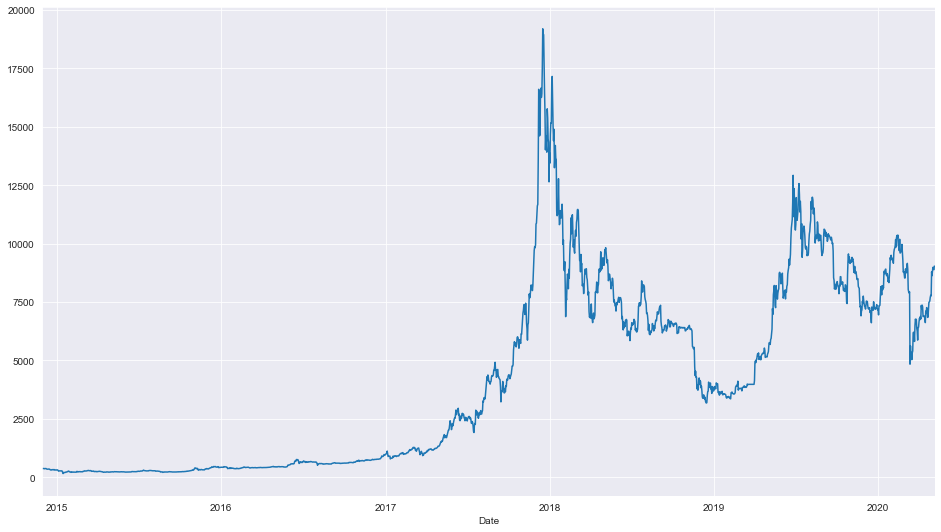

In [4]:
BTCUSD.Close.plot.line();

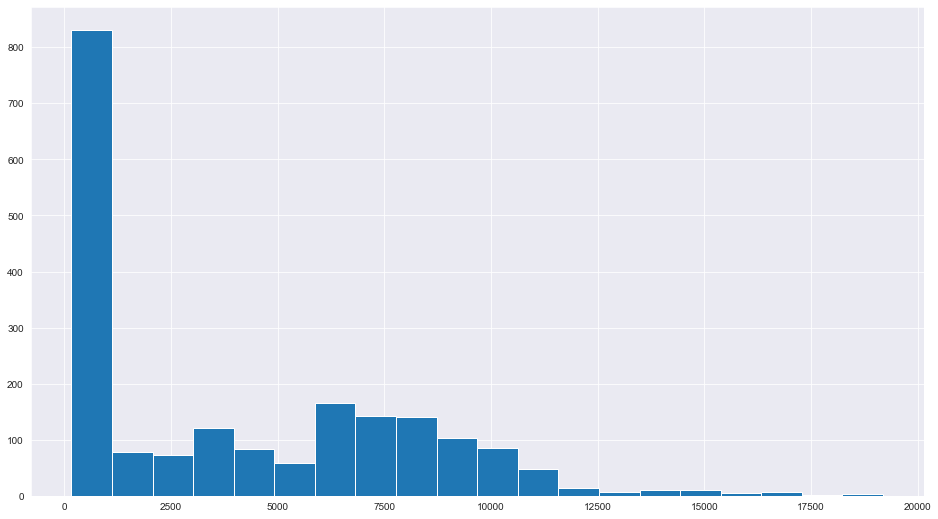

In [5]:
BTCUSD.Close.hist(bins=20);

In [6]:
BTCUSD.Close.mean(), BTCUSD.Close.std()

(4138.521867136386, 3965.7734851574455)

# 2. Seasonal Decomposition

After looking at the closing price and its histograms, let us look at the seasonal decomposition of the time series.

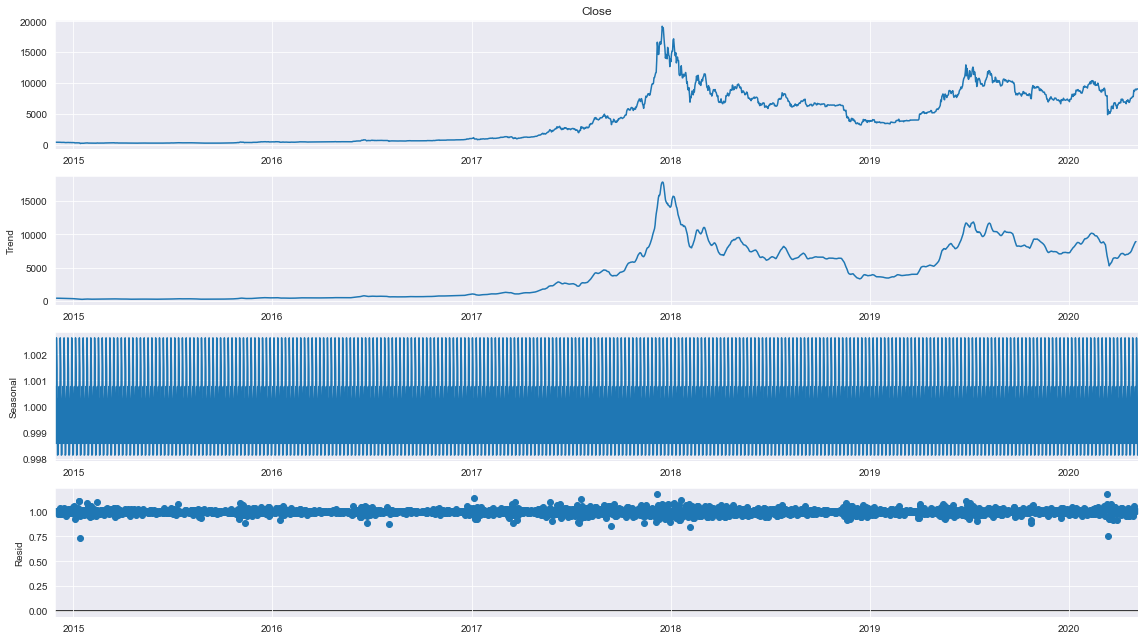

In [7]:
res = seasonal_decompose(BTCUSD['Close'], model='multiplicative')
fig = res.plot()

We will also visualize BTCUSD Close price and its autocorrelations. We will plot the correlation between current return with its one to 30 day lag return.

# 3. Auto Correlation Function (ACF) Tests

C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  This is separate from the ipykernel package so we can avoid doing imports until


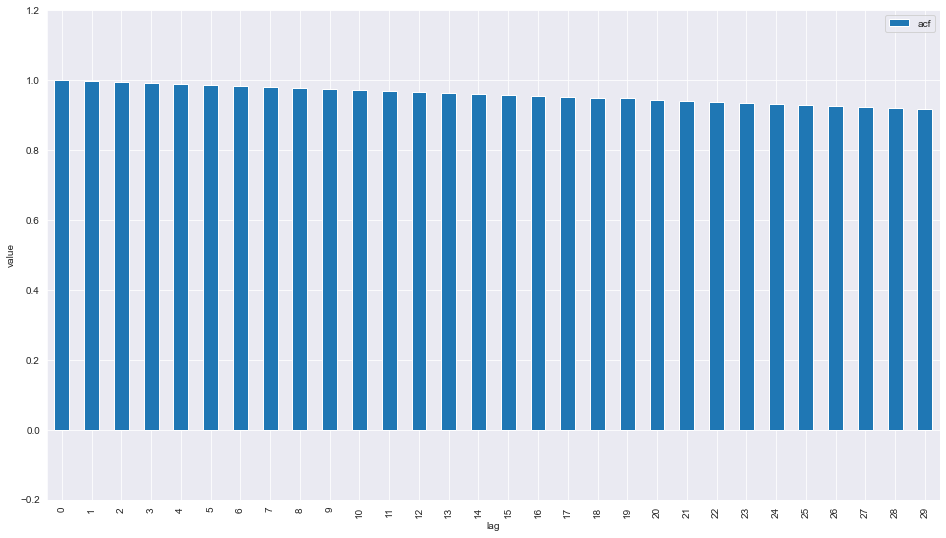

In [8]:
results = {}
nlags=30
results["acf"] = acf(BTCUSD.Close, unbiased=True, nlags=nlags-1, fft=False)

pd.DataFrame(results).plot(kind="bar", figsize=(16,9), grid=True)
plt.xlabel("lag")
plt.ylim([-0.2, 1.2])
plt.ylabel("value")
plt.show()

From the visualizations, we can conclude that the closing price of BTC is not a stationary time series, which means any predictive model trained for one period will not work for other periods.  

To further confirm our visual conclusion, let's run Dickey-Fuller test to test stationarity.

$H_0:$ BTCUSD Close price has an unit root, has a time-dependent structure and thus non-stationary.

In [9]:
# Check for log Close price series stationarity
result = adfuller(np.log(BTCUSD.Close))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.671617
p-value: 0.853965
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Since p-value > 0.05, we cannot reject $H_0$. Thus, BTCUSD Close price has a unit root, is non-stationary, and has time-dependent structure. 

# 4 Stationarity

Since BTCUSD Close is non stationary, we need to make it stationary for predictions. Time series usually has three components: `trend`, `seasonality`, and `residual`.  We can extract `trend` and `seasonality` away from the BTCUSD Close price and try to predict the `residuals`. But upon visual inspection of BTCUSD Close, There's no obvious trend nor seasonality. So we will make it stationary with its log returns. We use log returns instead of geometric or arithmetic returns as it is 1) log normal, 2) approximate raw-log equality, 3) time-additivity, and 4) ease of integration.

In [10]:
BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))
BTCUSD.dropna(inplace=True)

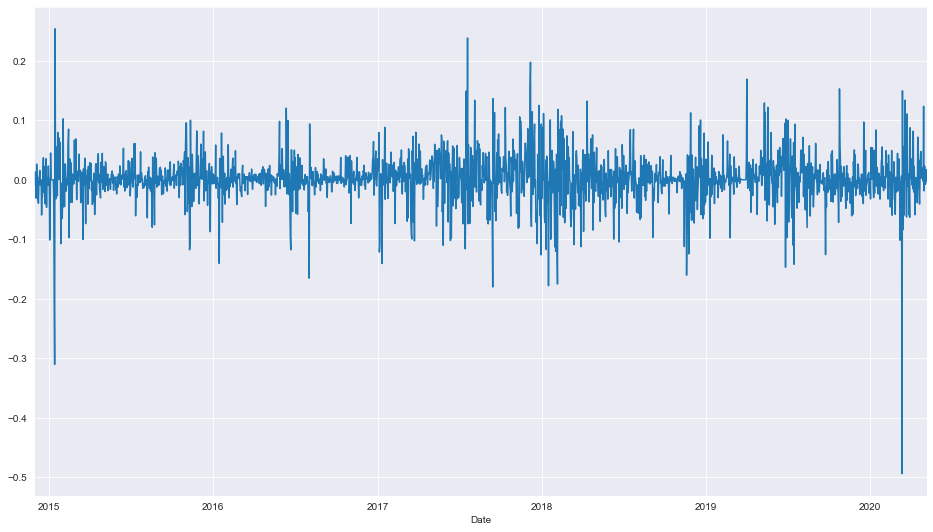

In [11]:
BTCUSD.log_ret.plot.line();

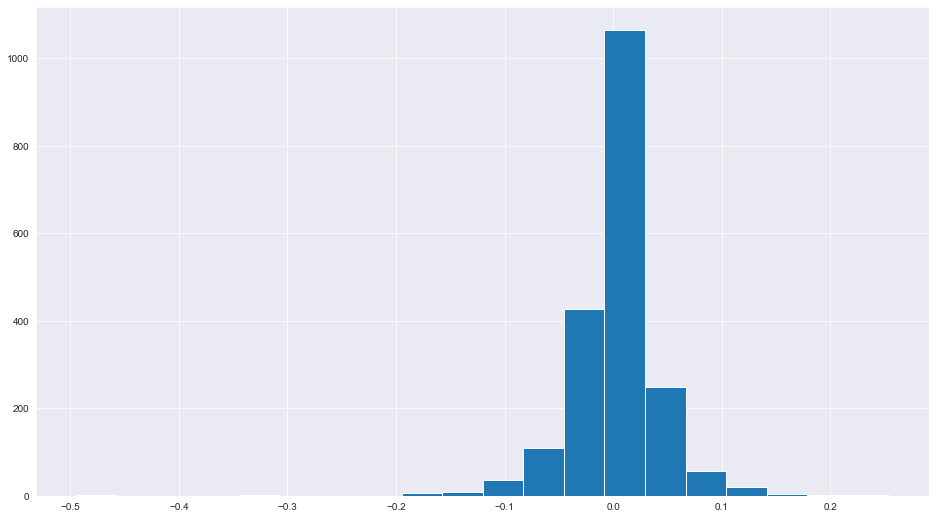

In [12]:
BTCUSD.log_ret.hist(bins=20, );

In [13]:
BTCUSD.log_ret.mean(), BTCUSD.log_ret.std()

(0.0015998704283798325, 0.040999221677222544)

Next, we will plot a correlogram to visualize the autocorrelations of log return of BTCUSD Close.

C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  This is separate from the ipykernel package so we can avoid doing imports until


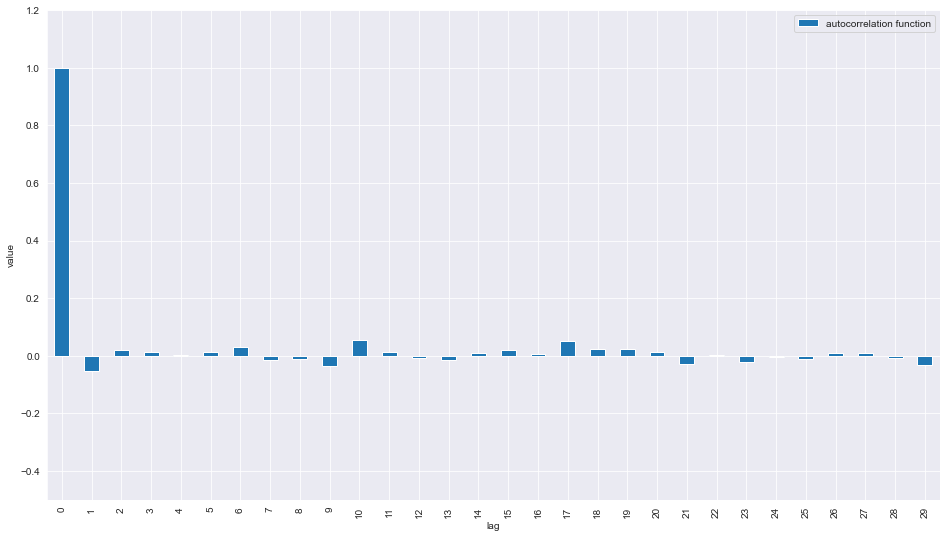

In [14]:
results = {}
nlags=30
results["autocorrelation function"] = acf(BTCUSD.log_ret, unbiased=True, nlags=nlags-1, fft=False)

pd.DataFrame(results).plot(kind="bar", figsize=(16,9), grid=True)
plt.xlabel("lag")
plt.ylim([-0.5, 1.2])
plt.ylabel("value")
plt.show()

The log return of closing price of BTCUSD looks like a stationary time series, which means any predictive model trained for one period will work for other periods.  Let's do a quick stationarirty test with Dickey-Fuller test.

$H_0:$ log return of BTCUSD Close has an unit root, has a time-dependent structure and thus non-stationary.

In [15]:
# Check for log_ret series stationarity.  
result = adfuller(BTCUSD.log_ret)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -46.958590
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Since p-value < 0.05, we can reject the null hypothesis that time series has a unit root and non-stationary and has time-dependent structure. Also, since we are able to achieve stationarity in first order differencing, we will not proceed to check higher order differencing.

Also, from the correlgram above, we see prounced autocorrelation at 3, 6, 10, 17, and 20 period lag. We will keep in mind when we engineer new features.

# 5. Summary Plot

C:\Users\Han\.virtualenvs\btc_predictor-newMfeuI\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


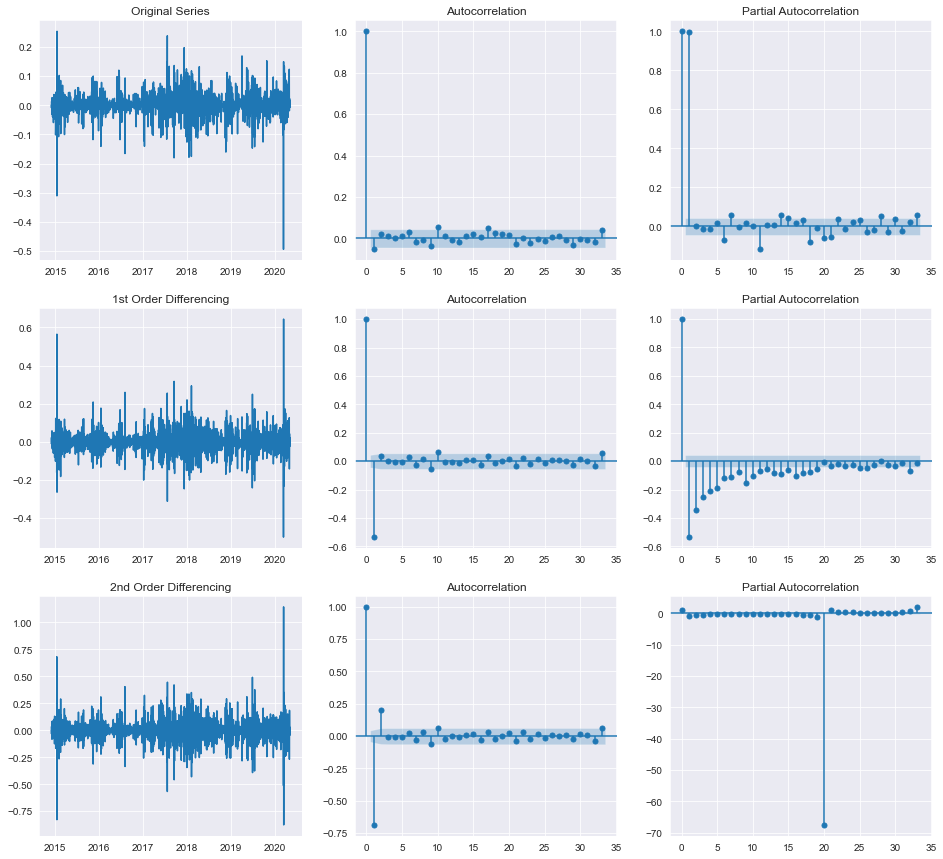

In [16]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(3, 3, figsize=(16,15), facecolor='white')

# original series
axes[0, 0].plot(BTCUSD.log_ret); axes[0, 0].set_title('Original Series')
plot_acf(BTCUSD.log_ret.dropna(), ax=axes[0,1])
plot_pacf(BTCUSD.Close.dropna(), ax=axes[0,2])

# 1st differencing
axes[1, 0].plot(BTCUSD.log_ret.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(BTCUSD.log_ret.diff().dropna(), ax=axes[1, 1])
plot_pacf(BTCUSD.log_ret.diff().dropna(), ax=axes[1, 2])

# 2nd differencing
axes[2, 0].plot(BTCUSD.log_ret.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(BTCUSD.log_ret.diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(BTCUSD.log_ret.diff().diff().dropna(), ax=axes[2, 2])

plt.show();

An ARIMA model has three parts. Autoregressive (AR), Integration (I), and moving average (MA) parts with corresponding parameters p, d, q.   

From the chart, we can see that zeroth order differencing makes our log return series stationary and first/second order differencing makes it overdifferenced with first lag significantly correlated. Thus, we choose first order differencing, or d equals 0.  

Looking at the partial autocorrelation chart of the 0th order differencing, the first statistically significant lag is at the 1st, thus we will choose AR parameter p to be 1.

Looking at the autocorrelation chart, the first statistically significant lag is again at the 1, thus we will choose MA paramter q to be 1.